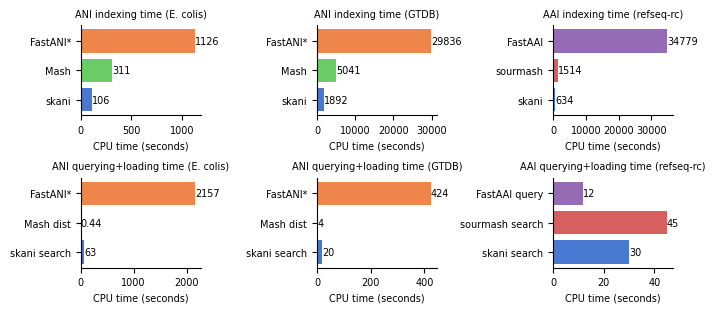

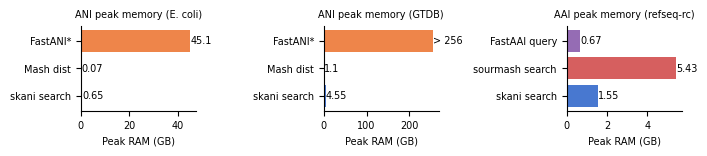

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats
import math
import numpy as np
import sys
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
wall = False
time = False
log_scale = False
cmap = sns.color_palette("muted")


#plt.style.use(['nature'])
#plt.style.reload_library()

def get_query_index_fastani_log(f):
    sketch_times = 0
    map_times = 0
    for line in open(f, 'r'):
        if 'sketching the reference' in line:
            sketch_times += float(line.split(':')[-1].split()[0])
        if 'spent mapping fragments' in line:
            map_times += float(line.split(':')[-1].split()[0])

    return map_times/(map_times + sketch_times)



def get_times_from_benchmark(f):
    counter = 0
    for line in open(f,'r'):
        if counter == 0:
            counter += 1
            continue
        else:
            spl = line.split('\t')
            wall_time = float(spl[0])
            max_rss = round(float(spl[2])/1000, 2)
            cpu_time = float(spl[-1])
            if cpu_time > 1:
                cpu_time = int(cpu_time)
            return [wall_time, cpu_time, max_rss]

def get_times_from_usrbintime(f):
    user_time = 0
    cpu_time = 0
    max_rss = 0
    wall_time = 0
    for line in open(f, 'r'):
        if 'User time' in line:
            user_time = float(line.split(':')[-1].rstrip())
        elif 'System time' in line:
            system_time = float(line.split(':')[-1].rstrip())
            cpu_time = user_time + system_time
        elif 'Maximum resident' in line:
            max_rss = round(float(line.split(':')[-1].rstrip())/1000000,2)
        elif 'wall clock' in line:
            str_time = line.split()[-1].rstrip()
            str_time = str_time.split(':');
            if len(str_time) == 3:
                wall_time = float(str_time[0]) * 3600 + float(str_time[1]) * 60 + float(str_time[2].rstrip())
            else:
                wall_time = float(str_time[0]) * 60 + float(str_time[1].rstrip())
    if cpu_time > 1:
        cpu_time = int(cpu_time)

    return [wall_time, cpu_time, max_rss]

times = [True, False]
for time in times:
    
    if time:
        plt.figure(figsize=(18*cm, 8*cm))
    else:
        plt.figure(figsize=(18*cm, 4*cm))

    aniu_D3 = "../results/times/bintime_aniuD3.txt"
    skani_D3 = "../results/times/skani_D3.time"
    skani_D3_index = "../results/times/bintime_skani_D3_sketch.time"
    skani_D3_dist = "../results/times/bintime_skani_D3_dist.time"
    skani_D3_search = "../results/times/bintime_skani_D3_query.time"
    fastani_D3 = "../results/times/fastani_D3.time"
    fastani_D3_log_file = "../results/times/fastani_D3.log"
    mash_D3 = "../results/times/mash_D3.time"
    mash_D3_index = "../results/times/mash_D3_sketch.time"
    mash_D3_dist = "../results/times/mash_D3_query.time"

    aniu_time = get_times_from_usrbintime(aniu_D3)
    skani_time = get_times_from_benchmark(skani_D3)
    skani_time_index = get_times_from_usrbintime(skani_D3_index)
    skani_time_dist = get_times_from_usrbintime(skani_D3_dist)
    skani_time_search = get_times_from_usrbintime(skani_D3_search)
    fastani_time = get_times_from_benchmark(fastani_D3)
    fastani_time_ratio= get_query_index_fastani_log(fastani_D3_log_file)
    mash_time = get_times_from_benchmark(mash_D3)
    mash_time_index = get_times_from_benchmark(mash_D3_index)
    mash_time_dist = get_times_from_benchmark(mash_D3_dist)
    rot = 0

    if time:
        colours = [cmap[0], cmap[2], cmap[1]]

        wall_times_index = [skani_time_index[0], mash_time_index[0], int(fastani_time[0] * (1 - fastani_time_ratio)), ]
        cpu_times_index = [skani_time_index[1], mash_time_index[1],  int(fastani_time[1] * (1-fastani_time_ratio)), ]
        labels = ["skani","Mash", "FastANI*"]
        ax = plt.subplot(2,3,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        if wall:
            bars = plt.barh([1,2,3], wall_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.bar_label(bars)
        #plt.hlines(y=skani_time_index[1] + skani_time_dist[1], xmin=1.5, xmax=3.5, linewidth=2, color=cmap[0], label = 'mash total time')
        #plt.hlines(y=mash_time_index[1] + mash_time_dist[1], xmin=4.5, xmax=6.5, linewidth=2, color=cmap[2], label = 'skani total time')
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.title("ANI indexing time (E. colis)", fontsize = 7 )

        labels = ["skani search",  "Mash dist", "FastANI*"]
        ax = plt.subplot(2,3,4)
        wall_times_search= [skani_time_search[0],  mash_time_dist[0], int(fastani_time[0] * fastani_time_ratio), ]
        cpu_times_search= [skani_time_search[1], mash_time_dist[1],  int(fastani_time[1] * fastani_time_ratio), ]

        colours = [cmap[0],  cmap[2], cmap[1]]
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        if wall:
            bars = plt.barh([1,2,3], wall_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.bar_label(bars)
        plt.title("ANI querying+loading time (E. colis)", fontsize = 7 )

    else:
        ax = plt.subplot(1,3,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        labels = ["skani search", "Mash dist", "FastANI*"]
        colours = [cmap[0], cmap[2], cmap[1]]
        memory_usage_all = [skani_time_search[2], mash_time_dist[2], fastani_time[2]]
        bars = plt.barh([1,2,3], memory_usage_all, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.bar_label(bars)

        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.xlabel("Peak RAM (GB)") 
        plt.title("ANI peak memory (E. colis)", fontsize = 7)


        #ax = plt.subplot(2,3,4)
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')
        #labels = ["skani search", "skani dist", "Mash", "FastANI*"]
        #colours = [cmap[0],cmap[0],cmap[2], cmap[1]]
        #memory_usage_all = [skani_time_search[2], skani_time_dist[2], mash_time_index[2], fastani_time[2]]
        #bars = plt.barh([1,2,3,4], memory_usage_all, log=log_scale, label=labels, tick_label = labels , color = colours)
        #plt.bar_label(bars)
        #plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        #plt.xlabel("Peak RAM (GB)") 
        #plt.title("ANI peak memory query (E. coli)", fontsize = 7)




    ezaai_refseq = "../results/times/bintime_aai_refseq.time"
    skani_aai_refseq = "../results/times/bintime_skani_refseq_all.time"
    skani_aai_refseq_index = "../results/times/bintime_skani_refseq_sketch.time"
    skani_aai_refseq_search = "../results/times/bintime_skani_refseq_query.time"
    skani_aai_refseq_dist = "../results/times/bintime_skani_refseq_dist.time"
    fastaai_refseq_index = "../results/times/bintime_fastaai_refseq_index.time"
    fastaai_refseq_dist = "../results/times/bintime_fastaai_refseq_query.time"
    sourmash_refseq_index = "../results/times/sourmash_refseq_index.time"
    sourmash_refseq_dist = "../results/times/sourmash_refseq_query.time"

    ezaai = get_times_from_usrbintime(ezaai_refseq)
    skani_aai = get_times_from_usrbintime(skani_aai_refseq)
    skani_aai_index = get_times_from_usrbintime(skani_aai_refseq_index)
    skani_aai_dist = get_times_from_usrbintime(skani_aai_refseq_dist)
    skani_aai_search = get_times_from_usrbintime(skani_aai_refseq_search)
    fastaai_index= get_times_from_usrbintime(fastaai_refseq_index)
    fastaai_dist= get_times_from_usrbintime(fastaai_refseq_dist)
    sourmash_index = get_times_from_benchmark(sourmash_refseq_index)
    sourmash_dist = get_times_from_benchmark(sourmash_refseq_dist)

    if time:
        colours = [cmap[0], cmap[3], cmap[4], ]
        wall_times_index = [ skani_aai_index[0],   sourmash_index[0], fastaai_index[0],]
        cpu_times_index = [ skani_aai_index[1],   sourmash_index[1],  fastaai_index[1],]
        labels = ["skani", "sourmash", "FastAAI"]
        ax = plt.subplot(2,3,3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        if wall:
            bars = plt.barh([1,2,3], wall_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.title("AAI indexing time (refseq-rc)", fontsize = 7)
        plt.bar_label(bars)

        colours = [cmap[0],   cmap[3], cmap[4], ]
        labels = ["skani search",  "sourmash search", "FastAAI query"]
        ax = plt.subplot(2,3,6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        wall_times_search = [ skani_aai_search[0],   sourmash_dist[0], fastaai_dist[0],]
        cpu_times_search = [ skani_aai_search[1],   sourmash_dist[1],  fastaai_dist[1],]

        if wall:
            bars = plt.barh([1,2,3], wall_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.title("AAI querying+loading time (refseq-rc)", fontsize = 7)
        plt.bar_label(bars)



    else:
        colours = [cmap[0],  cmap[3], cmap[4]]
        memory_usage_all = [skani_aai_search[2], sourmash_dist[2], max(fastaai_index[2],fastaai_dist[2])]
        labels = ["skani search",  "sourmash search","FastAAI query"]
        ax = plt.subplot(1,3,3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        bars = plt.barh([1,2,3], memory_usage_all, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.xlabel("Peak RAM (GB)") 
        plt.bar_label(bars)

        plt.title("AAI peak memory (refseq-rc)", fontsize = 7)

    ###THIRD PLOT
    skani_gtdb_index_file = "../results/times/bintime_skani_gtdb_sketch.time"
    skani_gtdb_search_file = "../results/times/bintime_skani_gtdb_query.time"
    skani_gtdb_dist_file = "../results/times/bintime_skani_gtdb_dist.time"
    mash_gtdb_index_file = "../results/times/bintime_mash_sketch_gtdb.time"
    mash_gtdb_search_file = "../results/times/bintime_mash_query_gtdb.time"
    fastani_gtdb_log_file = "../results/times/fastani_gtdb_log.time"
    fastani_gtdb_file = "../results/times/bintime_fastani_gtdb.time"

    skani_gtdb_index= get_times_from_usrbintime(skani_gtdb_index_file)
    skani_gtdb_search = get_times_from_usrbintime(skani_gtdb_search_file)
    skani_gtdb_dist = get_times_from_usrbintime(skani_gtdb_dist_file)
    mash_gtdb_index = get_times_from_usrbintime(mash_gtdb_index_file)
    mash_gtdb_dist = get_times_from_usrbintime(mash_gtdb_search_file)
    fastani_gtdb_all = get_times_from_usrbintime(fastani_gtdb_file)
    map_to_sketch_ratio = get_query_index_fastani_log(fastani_gtdb_log_file)

    if time:
        colours = [cmap[0],  cmap[2], cmap[1], ]
        wall_times_index = [skani_gtdb_index[0], mash_gtdb_index[0], int(fastani_gtdb_all[0] * (1-map_to_sketch_ratio))]
        cpu_times_index = [skani_gtdb_index[1], mash_gtdb_index[1], int(fastani_gtdb_all[1] * (1-map_to_sketch_ratio))]
        labels = ["skani", "Mash", "FastANI*" ]
        ax = plt.subplot(2,3,2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        if wall:
            bars = plt.barh([1,2,3], wall_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.bar_label(bars)
        #plt.hlines(y=skani_time_index[1] + skani_time_dist[1], xmin=1.5, xmax=3.5, linewidth=2, color=cmap[0], label = 'mash total time')
        #plt.hlines(y=mash_time_index[1] + mash_time_dist[1], xmin=4.5, xmax=6.5, linewidth=2, color=cmap[2], label = 'skani total time')
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.title("ANI indexing time (GTDB)", fontsize = 7)

        labels = ["skani search", "Mash dist", "FastANI*" ]
        colours = [cmap[0], cmap[2], cmap[1], ]
        wall_times_search = [skani_gtdb_search[0],  mash_gtdb_dist[0], int(fastani_gtdb_all[0] * (map_to_sketch_ratio))]
        cpu_times_search = [skani_gtdb_search[1],   mash_gtdb_dist[1], int(fastani_gtdb_all[1] * (map_to_sketch_ratio))]

        ax = plt.subplot(2,3,5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        if wall:
            bars = plt.barh([1,2,3], wall_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("Wall time (seconds)")
        else:
            bars = plt.barh([1,2,3], cpu_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
            plt.xlabel("CPU time (seconds)")
        plt.bar_label(bars)
        #plt.hlines(y=skani_time_index[1] + skani_time_dist[1], xmin=1.5, xmax=3.5, linewidth=2, color=cmap[0], label = 'mash total time')
        #plt.hlines(y=mash_time_index[1] + mash_time_dist[1], xmin=4.5, xmax=6.5, linewidth=2, color=cmap[2], label = 'skani total time')
        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.title("ANI querying+loading time (GTDB)", fontsize = 7)




    else:
        labels = ["skani search", "Mash dist", "FastANI*",]
        colours = [cmap[0], cmap[2], cmap[1]]
        ax = plt.subplot(1,3,2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        memory_usage_all = [skani_gtdb_search[2], mash_gtdb_dist[2], 256]
        bars = plt.barh([0,1,2], memory_usage_all, log=log_scale, label=labels, tick_label = labels , color = colours)
        #plt.xlim(])

        #plt.bar_label(bars)
        blabel = [str(skani_gtdb_search[2]), str(mash_gtdb_dist[2]),'> 256', ]
        plt.bar_label(bars, blabel)

        plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        plt.xlabel("Peak RAM (GB)") 
        plt.title("ANI peak memory (GTDB)", fontsize = 7)


        #labels = ["skani search","skani dist", "Mash"]
        #colours = [cmap[0], cmap[0], cmap[1]]
        #ax = plt.subplot(2,3,5)
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')

        #memory_usage_all = [skani_gtdb_search[2], skani_gtdb_dist[2], mash_gtdb_search[2]]
        #bars = plt.barh([0,1,2], memory_usage_all, log=log_scale, label=labels, tick_label = labels , color = colours)
        ##plt.xlim(])

        ##plt.bar_label(bars)
        #blabel = [str(skani_gtdb_search[2]), str(skani_gtdb_dist[2]),str( mash_gtdb_search[2])]
        #plt.bar_label(bars, blabel)

        #plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
        #plt.xlabel("Peak RAM (GB)") 
        #plt.title("ANI peak memory query (GTDB)", fontsize = 7)



    from matplotlib.offsetbox import AnchoredText
    s = "*-q = query *-i = index *-q-all = load all sketches *-q-partial = load sketch as needed"
    #plt.annotate(s, xy=(0.05, 0.95), xycoords='axes fraction')
    if time:
        if wall:
            plt.savefig('figures/runtimes_wall.svg', transparent = True)
        else:
            plt.savefig('figures/runtimes_cpu.svg', transparent = True)
    else:
        plt.savefig('figures/memory.svg', transparent = True)

    plt.show()
